# Coronavirus cases in Wales: How many hospital provide service in each county of Wlaes, UK? 

## For week 1

### A description of the problem and a discussion of the background. 

Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people who fall sick with COVID-19 will experience mild to moderate symptoms and recover without special treatment. However, a part of people could show severe symptoms and need professional medical machines to save lives. 

The major challenges to medical service come from two aspects:
1. a large number of suspect cases that need consultation and diagnoses service from hospitals 
2. COVID-19 as a novel antigen that the human immune system did not have memory immune responses to fight back that patients could be easy to show symptoms and need professional medical machines, like breathing machine.

3. Also, human-to-human transmission as the major transmission pathway that population density could show a positive relation with infection cases.

**More infection cases need more medical resources. My question here is whether the number of local hospital is positive related to the number of infection cases? Whether there is any obvious shortage on medical resources that cannot afford a large number of patients.**

### A description of the data and how it will be used to solve the problem.
Here, I look into a small area of the United Kingdom, Wales. 
* Data collection:
I downloaded infection cases in each county of wales updated on 12-May-2020 from New York Times, and population density information by Wikipedia. I used foursquare to search hospitals in each county and select those could provide medical service for patients into the analysis.

1. Show the folium map of Wales and  chloroma shows the population density of each county.
2. Mark in the folium map with dots, and the radius is related to the number of infection.
3. Use geopy to acquire the location of center of each county.
4. Use foursquare to search the hospital information with the center of each county.
5. Clean data to remove types of hospital cannot provide service to patients.
6. Provide information of number of different types of hospital in each county.
7. Plot different attribuates with infection cases to see whether there is any clear positive correlation.

# For week 2

## A link to your Notebook on your Github repository, showing your code

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Data preparation: The New York Times website contains an json file which have detailed information about the Coronavirus infection information in the UK.

 It contins three major parts of information:
    * Basic: name of each region, population of each region, region type and hierarchy.
    * Date information: start date, latest update date,duration of being infected.
    * Infection cases information: daliy increased cases, daily increased deaths, all cases, all deaths and recovered. However, some of data are missing and cannot be imputed: daily increased deaths,  all deaths and recovered for counties. Here, I will only consider the all cases instead.

In [286]:
# Download Data from NewYork Time html linked jason file (https://www.nytimes.com/interactive/2020/world/europe/united-kingdom-coronavirus-cases.html)
!wget -q -O 'GBR.json' https://static01.nyt.com/newsgraphics/2020/03/16/coronavirus-maps/de872938ac8dbefaa1cb6a798151fca06ad189d3/data/timeseries/GBR.json
print('Data downloaded!')

Data downloaded!


In [3]:
with open('GBR.json') as json_data:
    UK_data = json.load(json_data)

In [4]:
# Notice how all the relevant data is in the data key. So, define a new variable that includes this data.
raw_data = UK_data['data']

In [65]:
# define the dataframe columns
column_names = ['District','hierarchy','population','region_type','length','first','last','Cases','deaths','recovered'] 

# instantiate the dataframe
UK_cov = pd.DataFrame(columns=column_names)

In [66]:
UK_cov

Empty DataFrame
Columns: [District, hierarchy, population, region_type, length, first, last, Cases, deaths, recovered]
Index: []

In [67]:
for data in raw_data [1:] :
    Name= data ['display_name']
    hierarchy = data ['hierarchy'][-1]
    population= data ['population']
    region_type= data ['region_type']
    length= data ['length']
    first= data ['first']
    last= data ['last']
    cases= data ['all_cases'][-1]
    deaths= data ['all_deaths'][-1]
    recovered= data ['recovered'][-1]
  
    UK_cov = UK_cov.append({'District':Name,
                                          'hierarchy': hierarchy,
                                          'population': population,
                                          'region_type': region_type,
                                          'length':  length,
                                          'first': first,
                                          'last': last,
                                          'Cases': cases,
                                          'deaths': deaths,
                                          'recovered': recovered}, 
                                           ignore_index=True)

In [68]:
 UK_cov.head()

District                hierarchy population  \
0          Barking and Dagenham           NYT-GBR-London     185911   
1                        Barnet           NYT-GBR-London     356386   
2                      Barnsley  NYT-GBR-South Yorkshire     231221   
3  Bath and North East Somerset              GBR-England     176016   
4                       Bedford              GBR-England     157479   

  region_type length       first        last Cases deaths recovered  
0      county     34  2020-04-09  2020-05-11   477      0         0  
1      county     34  2020-04-09  2020-05-11  1252      0         0  
2      county     34  2020-04-09  2020-05-11   775      0         0  
3      county     34  2020-04-09  2020-05-11   223      0         0  
4      county     34  2020-04-09  2020-05-11   504      0         0

In [69]:
 UK_cov.shape

(197, 10)

Since all the areas still have infection cases until 2020-05-11 and all recovered are 0, which should be missing, I drop the redundency information of Last and recovered here. Also, hierarchy need to be modified into more meaningful.

In [70]:
UK_cov_1=UK_cov.drop(['recovered','last'],axis=1)
UK_cov_1.shape

(197, 8)

In [78]:
UK_cov_1.head()

District                hierarchy population  \
0          Barking and Dagenham           NYT-GBR-London     185911   
1                        Barnet           NYT-GBR-London     356386   
2                      Barnsley  NYT-GBR-South Yorkshire     231221   
3  Bath and North East Somerset              GBR-England     176016   
4                       Bedford              GBR-England     157479   

  region_type length       first Cases deaths  
0      county     34  2020-04-09   477      0  
1      county     34  2020-04-09  1252      0  
2      county     34  2020-04-09   775      0  
3      county     34  2020-04-09   223      0  
4      county     34  2020-04-09   504      0

Normalize the text content in UK_cov_1['hierarchy']

Select the subset of Wales as the target to study. Rename the "GBR-Wales" into'Wales" and only keep meaningful data of Name, Population and cases.

In [72]:
Wales = UK_cov_1[UK_cov_1["hierarchy"] =='GBR-Wales']

In [75]:
Wales.reset_index(drop=True, inplace=True)
Wales['hierarchy'].replace('GBR-Wales','Wales',inplace=True)
Wales.head()

/Users/YJ1214/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


District hierarchy population region_type length       first Cases  \
0       Anglesey     Wales      69751      county     30  2020-04-13   130   
1  Blaenau Gwent     Wales      69814      county     30  2020-04-13   310   
2       Bridgend     Wales     139178      county     30  2020-04-13   448   
3     Caerphilly     Wales     178806      county     30  2020-04-13   635   
4        Cardiff     Wales     346090      county     30  2020-04-13  1842   

  deaths  
0      0  
1      0  
2      0  
3      0  
4      0

In [109]:
Wales_final=Wales[['District','Cases']]
Wales_final['Cases']=Wales_final['Cases'].astype(int)
Wales_final.head()

/Users/YJ1214/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


District  Cases
0       Anglesey    130
1  Blaenau Gwent    310
2       Bridgend    448
3     Caerphilly    635
4        Cardiff   1842

# Provide more area information to original cases dataform

One thing need to notice here that the population number given by The New York Times source are dramatically less than wikipedia, so here population information from pervious dataform are replaced by wiki source data

In [54]:
# Area information and population density
link1='https://en.wikipedia.org/wiki/List_of_Welsh_principal_areas_by_population'
link2='https://en.wikipedia.org/wiki/List_of_Welsh_principal_areas_by_area'
pod=pd.read_html(link1)
area=pd.read_html(link2)

In [56]:
pop1=pod[0].drop(['Rank'],axis=1)
area1=area[1].drop(['Rank','Style'],axis=1)

In [96]:
pop1['District'].replace('Isle of Anglesey','Anglesey',inplace=True)
area1['Area (km²)'].replace('2,370 [3]','2370',inplace=True)
area1['Area (km²)'].replace('2,535 [2]','2535',inplace=True)
area1['Area (km²)'].replace('5,180 [1]','5180',inplace=True)
popu=pop1.sort_values(by='District')
areau=area1.sort_values(by='District')
popu.reset_index(drop=True, inplace=True)
areau.reset_index(drop=True, inplace=True)

District      object
Area (km²)    object
dtype: object

In [104]:
areau['Area (km²)']= areau['Area (km²)'].astype(int)
areau.dtypes

District      object
Area (km²)     int64
dtype: object

In [477]:
m1 = pd.merge(popu,areau,how='left', on=['District'])
df = pd.merge(Wales_final,m1,how='left', on=['District'])
df.head()

District  Cases  Population  Populationdensity/km²            Style  \
0       Anglesey    130       69961                     98           County   
1  Blaenau Gwent    310       69713                    641   County borough   
2       Bridgend    448      144876                    578   County borough   
3     Caerphilly    635      181019                    653   County borough   
4        Cardiff   1842      364248                   2585  City and county   

   Area (km²)  
0         714  
1         109  
2         246  
3         278  
4         140

In [111]:
df.dtypes

District                 object
Cases                     int64
Population                int64
Populationdensity/km²     int64
Style                    object
Area (km²)                int64
dtype: object

# Get latitude and longitude values for each district, and show on the folium map of Wales

In [112]:
# Define information need to acquire 
df['lat']=None
df['lon']=None

In [114]:
#Acquire latitude and longitude information for each area
import geocoder
for i in range(0,len(df['District'])):
    g=geocoder.arcgis('{}, Wales,UK'.format(df['District'][i]))
    df['lat'][i]=g.latlng[0]
    df['lon'][i]=g.latlng[1]

/Users/YJ1214/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/YJ1214/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [116]:
df.head()

District  Cases  Population  Populationdensity/km²            Style  \
0       Anglesey    130       69961                     98           County   
1  Blaenau Gwent    310       69713                    641   County borough   
2       Bridgend    448      144876                    578   County borough   
3     Caerphilly    635      181019                    653   County borough   
4        Cardiff   1842      364248                   2585  City and county   

   Area (km²)      lat      lon  
0         714    53.25 -4.33333  
1         109  51.7668 -3.19378  
2         246  51.5088 -3.57822  
3         278  51.5766 -3.21771  
4         140  51.4813 -3.18072

In [117]:
address = 'Wales,UK'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Wales,UK are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Wales,UK are 52.2928116, -3.73893.


In [162]:
# create map of Wales,UK using latitude and longitude values
map_Wales = folium.Map(location=[latitude, longitude], zoom_start=7.5)

In [155]:
# download countries geojson file
!wget --quiet  https://s3-eu-west-1.amazonaws.com/jupyter-gmaps-examples/england-counties.geo.json -O wales.json  
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [156]:
import json
import requests
wales_geo = r'wales.json' # geojson file

In [163]:
# generate choropleth map using the population of each area of Wales
map_Wales.choropleth(
    geo_data=wales_geo,
    data=df,
    columns=['District', 'Populationdensity/km²'],
    key_on='feature.properties.ctyua15nm',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Populationdensity of Wales'
)

# display map
map_Wales

In [164]:
# add markers to map
for lat, lon, District, rad in zip(df['lat'],df['lon'],df['District'],df["Cases"]):
    label = '{}'.format(District)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=rad/100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Wales)  
    
map_Wales

This Figure shows the location of each county and radius means the number of identified Cov19 cases/1000 (Update to May-11-2020).The Color of each area is related to the population density number. It is obvious that the population density positively relate to number of infection confirm cases.

It is interesting to observe that Blaenau Gwent, Merthyr Tydfil and Torfaen share a similar density with Rhondda Cynon Taf, Newport, Caerphilly and Swansea, but the infection cases is significantly less than the last four county. 

The number of hospital shows the burden of local treatment can afford. Here, to understand the reason, I collect information of the number of hospitals , number of train stations and number of airports in each area , distance from each county central to Cardiff.

## Define Foursquare Credentials and Version, explore local information in the dataframe

In [167]:
CLIENT_ID = 'MFQBSEZGRMVVG00KFJ1A4XK4MBSR5031MUOH0KWSXDE4AD0Q' # your Foursquare ID
CLIENT_SECRET = 'RPRADK3JGDFIOPTSLRWDT34BRLE3HBDI22JDUPSNMKJXKPUL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
search_query = 'Hospital'
categoryId = '4bf58dd8d48988d104941735'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MFQBSEZGRMVVG00KFJ1A4XK4MBSR5031MUOH0KWSXDE4AD0Q
CLIENT_SECRET:RPRADK3JGDFIOPTSLRWDT34BRLE3HBDI22JDUPSNMKJXKPUL


### Here is a test using the first reion in the df, to format the result are more Readable 

In [179]:
# It could be difficult to search by boundries,so I estimate radius calculated from area
import math
district_latitude = df.loc[0, 'lat'] # neighborhood latitude value
district_longitude = df.loc[0, 'lon'] # neighborhood longitude value
district_area = df.loc[0,'Area (km²)'] # neighborhood area value
district_radius = math.sqrt (district_area/math.pi)*1000
district_name = df.loc[0, 'District'] # neighborhood name

print('Radius, Latitude and longitude values of {} are {}, {}, {}.'.format(district_name, 
                                                               district_radius,
                                                               district_latitude, 
                                                               district_longitude))

Radius, Latitude and longitude values of Anglesey are 15075.584855494879, 53.25000000000006, -4.333329999999933.


In [198]:
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, CLIENT_SECRET, district_latitude, district_longitude, VERSION, search_query,  district_radius, LIMIT, categoryId)
url

'https://api.foursquare.com/v2/venues/search?client_id=MFQBSEZGRMVVG00KFJ1A4XK4MBSR5031MUOH0KWSXDE4AD0Q&client_secret=RPRADK3JGDFIOPTSLRWDT34BRLE3HBDI22JDUPSNMKJXKPUL&ll=53.25000000000006,-4.333329999999933&v=20180605&query=Hospital&radius=15075.584855494879&limit=100&categoryId=4bf58dd8d48988d104941735'

In [331]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ebb9d28be61c9001b253934'},
 'response': {'venues': [{'id': '4e8b16768b810d8892938bc0',
    'name': 'Cefni Hospital',
    'location': {'lat': 53.256430876528746,
     'lng': -4.305010678498121,
     'labeledLatLngs': [{'label': 'display',
       'lat': 53.256430876528746,
       'lng': -4.305010678498121}],
     'distance': 2017,
     'postalCode': 'll77 7tp',
     'cc': 'GB',
     'country': 'United Kingdom',
     'formattedAddress': ['ll77 7tp', 'United Kingdom']},
    'categories': [{'id': '4bf58dd8d48988d196941735',
      'name': 'Hospital',
      'pluralName': 'Hospitals',
      'shortName': 'Hospital',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/medical_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1589353763',
    'hasPerk': False},
   {'id': '507ded9fe4b00deec9e8d5fb',
    'name': 'hospital',
    'location': {'lat': 53.21348571777344,
     'lng': -4.159536361694336,
     'labeledLatL

In [332]:
venues = results['response']['venues']


In [401]:
for a in venues:
    print (a['categories'][0]['name'])

Hospital
Emergency Room
Hospital
Hospital


In [235]:
# filter columns
filtered_columns = ['name', 'categories','location.lat','location.lng','location.distance','location.cc']
nearby_venues =nearby_venues.loc[:, filtered_columns]

name                                         categories  \
0   Cefni Hospital  [{'id': '4bf58dd8d48988d196941735', 'name': 'H...   
1         hospital  [{'id': '4bf58dd8d48988d194941735', 'name': 'E...   
2   Eryri Hospital  [{'id': '4bf58dd8d48988d196941735', 'name': 'H...   
3  Bangor Hospital  [{'id': '4bf58dd8d48988d196941735', 'name': 'H...   

   location.lat  location.lng  location.distance location.cc  
0     53.256431     -4.305011               2017          GB  
1     53.213486     -4.159536              12273          GB  
2     53.129531     -4.263648              14193          GB  
3     53.209964     -4.160335              12359          GB

In [260]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['cat']
    except:
        categories_list = row['categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [261]:
# filter the category for each row
nearby_venues ['categories'] = nearby_venues.apply(get_category_type, axis=1)

In [262]:
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name      categories        lat       lng  distance  cc
0   Cefni Hospital        Hospital  53.256431 -4.305011      2017  GB
1         hospital  Emergency Room  53.213486 -4.159536     12273  GB
2   Eryri Hospital        Hospital  53.129531 -4.263648     14193  GB
3  Bangor Hospital        Hospital  53.209964 -4.160335     12359  GB

### Search hospital for each county

In [445]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    search_query = 'Hospital'
    categoryId = '4bf58dd8d48988d104941735'
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        radi=math.sqrt(rad/math.pi)*1000
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radi, LIMIT, categoryId)
        
        # make the GET request
        results = requests.get(url).json()['response']['venues']
       
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    return(nearby_venues)

In [446]:
df_hospital=getNearbyVenues(names=df['District'], latitudes=df['lat'], longitudes=df['lon'], radius=df['Area (km²)'])

KeyError: 'venues'

In [447]:
df_hospital

District  District Latitude  District Longitude  \
0             Anglesey          53.250000           -4.333330   
1             Anglesey          53.250000           -4.333330   
2             Anglesey          53.250000           -4.333330   
3             Anglesey          53.250000           -4.333330   
4        Blaenau Gwent          51.766776           -3.193783   
5        Blaenau Gwent          51.766776           -3.193783   
6             Bridgend          51.508840           -3.578220   
7             Bridgend          51.508840           -3.578220   
8             Bridgend          51.508840           -3.578220   
9             Bridgend          51.508840           -3.578220   
10            Bridgend          51.508840           -3.578220   
11            Bridgend          51.508840           -3.578220   
12          Caerphilly          51.576580           -3.217710   
13          Caerphilly          51.576580           -3.217710   
14          Caerphilly          51.576580           -3.217710   
15          Caerphilly          51.576580           -3.217710   
16          Caerphilly          51.576580           -3.217710   
17          Caerphilly          51.576580           -3.217710   
18          Caerphilly          51.576580           -3.217710   
19          Caerphilly          51.576580           -3.217710   
20          Caerphilly          51.576580           -3.217710   
21          Caerphilly          51.576580           -3.217710   
22          Caerphilly          51.576580           -3.217710   
23          Caerphilly          51.576580           -3.217710   
24          Caerphilly          51.576580           -3.217710   
25          Caerphilly          51.576580           -3.217710   
26          Caerphilly          51.576580           -3.217710   
27          Caerphilly          51.576580           -3.217710   
28          Caerphilly          51.576580           -3.217710   
29          Caerphilly          51.576580           -3.217710   
30          Caerphilly          51.576580           -3.217710   
31          Caerphilly          51.576580           -3.217710   
32          Caerphilly          51.576580           -3.217710   
33          Caerphilly          51.576580           -3.217710   
34          Caerphilly          51.576580           -3.217710   
35          Caerphilly          51.576580           -3.217710   
36          Caerphilly          51.576580           -3.217710   
37          Caerphilly          51.576580           -3.217710   
38          Caerphilly          51.576580           -3.217710   
39          Caerphilly          51.576580           -3.217710   
40          Caerphilly          51.576580           -3.217710   
41          Caerphilly          51.576580           -3.217710   
42          Caerphilly          51.576580           -3.217710   
43          Caerphilly          51.576580           -3.217710   
44          Caerphilly          51.576580           -3.217710   
45             Cardiff          51.481270           -3.180720   
46             Cardiff          51.481270           -3.180720   
47             Cardiff          51.481270           -3.180720   
48             Cardiff          51.481270           -3.180720   
49             Cardiff          51.481270           -3.180720   
50             Cardiff          51.481270           -3.180720   
51             Cardiff          51.481270           -3.180720   
52             Cardiff          51.481270           -3.180720   
53             Cardiff          51.481270           -3.180720   
54             Cardiff          51.481270           -3.180720   
55             Cardiff          51.481270           -3.180720   
56             Cardiff          51.481270           -3.180720   
57             Cardiff          51.481270           -3.180720   
58             Cardiff          51.481270           -3.180720   
59             Cardiff          51.481270           -3.180720   
60             Cardiff          51.481270        

In [448]:
df_hospital['Venue Category'].unique()

array(['Hospital', 'Emergency Room', "Doctor's Office", 'Veterinarian',
       'Hospital Ward', "Dentist's Office", 'Office',
       'Urgent Care Center', 'Medical Center', 'Memorial Site',
       'Mental Health Office'], dtype=object)

In [455]:
# It is clear that only 'Hospital', 'Emergency Room', 'Hospital Ward', 'Urgent Care Center' and 'Medical Center' can enroll in fighting with viruses, so I drop and rows are not these category.
filt=['Hospital', 'Emergency Room', 'Hospital Ward', 'Urgent Care Center', 'Medical Center']
df1=df_hospital[df_hospital['Venue Category'].isin(filt)]
df1

District  District Latitude  District Longitude  \
0             Anglesey          53.250000           -4.333330   
1             Anglesey          53.250000           -4.333330   
2             Anglesey          53.250000           -4.333330   
3             Anglesey          53.250000           -4.333330   
4        Blaenau Gwent          51.766776           -3.193783   
5        Blaenau Gwent          51.766776           -3.193783   
6             Bridgend          51.508840           -3.578220   
8             Bridgend          51.508840           -3.578220   
10            Bridgend          51.508840           -3.578220   
11            Bridgend          51.508840           -3.578220   
12          Caerphilly          51.576580           -3.217710   
14          Caerphilly          51.576580           -3.217710   
15          Caerphilly          51.576580           -3.217710   
16          Caerphilly          51.576580           -3.217710   
17          Caerphilly          51.576580           -3.217710   
18          Caerphilly          51.576580           -3.217710   
22          Caerphilly          51.576580           -3.217710   
23          Caerphilly          51.576580           -3.217710   
24          Caerphilly          51.576580           -3.217710   
25          Caerphilly          51.576580           -3.217710   
28          Caerphilly          51.576580           -3.217710   
29          Caerphilly          51.576580           -3.217710   
30          Caerphilly          51.576580           -3.217710   
31          Caerphilly          51.576580           -3.217710   
32          Caerphilly          51.576580           -3.217710   
33          Caerphilly          51.576580           -3.217710   
34          Caerphilly          51.576580           -3.217710   
35          Caerphilly          51.576580           -3.217710   
36          Caerphilly          51.576580           -3.217710   
37          Caerphilly          51.576580           -3.217710   
38          Caerphilly          51.576580           -3.217710   
39          Caerphilly          51.576580           -3.217710   
40          Caerphilly          51.576580           -3.217710   
41          Caerphilly          51.576580           -3.217710   
43          Caerphilly          51.576580           -3.217710   
44          Caerphilly          51.576580           -3.217710   
45             Cardiff          51.481270           -3.180720   
47             Cardiff          51.481270           -3.180720   
49             Cardiff          51.481270           -3.180720   
50             Cardiff          51.481270           -3.180720   
51             Cardiff          51.481270           -3.180720   
53             Cardiff          51.481270           -3.180720   
55             Cardiff          51.481270           -3.180720   
56             Cardiff          51.481270           -3.180720   
57             Cardiff          51.481270           -3.180720   
59             Cardiff          51.481270           -3.180720   
60             Cardiff          51.481270           -3.180720   
61             Cardiff          51.481270           -3.180720   
62             Cardiff          51.481270           -3.180720   
63             Cardiff          51.481270           -3.180720   
64             Cardiff          51.481270           -3.180720   
65             Cardiff          51.481270           -3.180720   
66             Cardiff          51.481270           -3.180720   
67             Cardiff          51.481270           -3.180720   
69             Cardiff          51.481270           -3.180720   
70             Cardiff          51.481270           -3.180720   
73             Cardiff          51.481270           -3.180720   
74             Cardiff          51.481270           -3.180720   
75     Carmarthenshire          51.903699           -4.164224   
76     Carmarthenshire          51.903699           -4.164224   
77     Carmarthenshire          51.903699        

In [456]:
df1.groupby('District').count()

District Latitude  District Longitude  Venue  \
District                                                          
Anglesey                           4                   4      4   
Blaenau Gwent                      2                   2      2   
Bridgend                           4                   4      4   
Caerphilly                        26                  26     26   
Cardiff                           22                  22     22   
Carmarthenshire                    9                   9      9   
Ceredigion                         4                   4      4   
Conwy                              3                   3      3   
Denbighshire                       4                   4      4   
Flintshire                         5                   5      5   
Gwynedd                            2                   2      2   
Merthyr Tydfil                     5                   5      5   
Monmouthshire                      7                   7      7   
Neath Port Talbot                  5                   5      5   
Newport                            6                   6      6   
Pembrokeshire                      4                   4      4   
Powys                             12                  12     12   
Rhondda Cynon Taf                 14                  14     14   
Swansea                            9                   9      9   
Torfaen                            1                   1      1   
Vale of Glamorgan                  7                   7      7   
Wrexham                            8                   8      8   

                   Venue Latitude  Venue Longitude  Venue Category  
District                                                            
Anglesey                        4                4               4  
Blaenau Gwent                   2                2               2  
Bridgend                        4                4               4  
Caerphilly                     26               26              26  
Cardiff                        22               22              22  
Carmarthenshire                 9                9               9  
Ceredigion                      4                4               4  
Conwy                           3                3               3  
Denbighshire                    4                4               4  
Flintshire                      5                5               5  
Gwynedd                         2                2               2  
Merthyr Tydfil                  5                5               5  
Monmouthshire                   7                7               7  
Neath Port Talbot               5                5               5  
Newport                         6                6               6  
Pembrokeshire                   4                4               4  
Powys                          12               12              12  
Rhondda Cynon Taf              14               14              14  
Swansea                         9                9               9  
Torfaen                         1                1               1  
Vale of Glamorgan               7                7               7  
Wrexham                         8                8               8

In [465]:
# one hot encoding
wales_hospital_onehot = pd.get_dummies(df1[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
wales_hospital_onehot['District'] = df1['District'] 

In [466]:
wales_hospital_onehot

Emergency Room  Hospital  Hospital Ward  Medical Center  \
0                 0         1              0               0   
1                 1         0              0               0   
2                 0         1              0               0   
3                 0         1              0               0   
4                 0         1              0               0   
5                 0         1              0               0   
6                 0         1              0               0   
8                 1         0              0               0   
10                0         1              0               0   
11                0         0              1               0   
12                0         1              0               0   
14                0         1              0               0   
15                0         0              1               0   
16                0         1              0               0   
17                0         1              0               0   
18                0         1              0               0   
22                0         1              0               0   
23                0         0              1               0   
24                0         1              0               0   
25                0         1              0               0   
28                0         1              0               0   
29                0         1              0               0   
30                0         1              0               0   
31                0         0              1               0   
32                0         1              0               0   
33                0         1              0               0   
34                0         0              1               0   
35                0         0              1               0   
36                1         0              0               0   
37                0         1              0               0   
38                0         0              0               0   
39                0         0              0               0   
40                0         1              0               0   
41                0         0              1               0   
43                0         0              1               0   
44                0         1              0               0   
45                0         1              0               0   
47                0         1              0               0   
49                0         0              1               0   
50                0         0              0               1   
51                0         1              0               0   
53                0         1              0               0   
55                0         1              0               0   
56                0         0              1               0   
57                0         1              0               0   
59                0         1              0               0   
60                0         1              0               0   
61                0         1              0               0   
62                0         0              1               0   
63                1         0              0               0   
64                0         0              0               0   
65                0         0              0               0   
66                0         1              0               0   
67                0         0              1               0   
69                0         0              1               0   
70                0         1              0               0   
73                0         0              1               0   
74                0         1              0               0   
75                0         1              0               0   
76                0         1              0               0   
77                0         1              0               0   
78                0         1        

In [467]:
# move district column to the first column
fixed_columns = [wales_hospital_onehot.columns[-1]] + list(wales_hospital_onehot.columns[:-1])
wales_hospital_onehot = wales_hospital_onehot[fixed_columns]

wales_hospital_onehot.head()

District  Emergency Room  Hospital  Hospital Ward  Medical Center  \
0       Anglesey               0         1              0               0   
1       Anglesey               1         0              0               0   
2       Anglesey               0         1              0               0   
3       Anglesey               0         1              0               0   
4  Blaenau Gwent               0         1              0               0   

   Urgent Care Center  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

In [488]:
wales_hospital_grouped = wales_hospital_onehot.groupby('District').sum().reset_index()
wales_hospital_grouped['hospital_sum']=wales_hospital_grouped['Emergency Room']+wales_hospital_grouped['Hospital']+wales_hospital_grouped['Hospital Ward']+wales_hospital_grouped['Medical Center']+wales_hospital_grouped['Urgent Care Center']
wales_hospital_grouped()

TypeError: 'DataFrame' object is not callable

In [486]:
wales_hospital_merged=df
# merge wales_hospital_grouped with wales basic infection info to add latitude/longitude for each neighborhood
wales_hospital_merged = wales_hospital_merged.join(wales_hospital_grouped.set_index('District'), on='District')

In [506]:
wales_hospital_merged.head()

District  Cases  Population  Populationdensity/km²            Style  \
0       Anglesey    130       69961                     98           County   
1  Blaenau Gwent    310       69713                    641   County borough   
2       Bridgend    448      144876                    578   County borough   
3     Caerphilly    635      181019                    653   County borough   
4        Cardiff   1842      364248                   2585  City and county   

   Area (km²)  Emergency Room  Hospital  Hospital Ward  Medical Center  \
0         714               1         3              0               0   
1         109               0         2              0               0   
2         246               1         2              1               0   
3         278               1        16              7               0   
4         140               1        12              6               1   

   Urgent Care Center  hospital_sum  
0                   0             4  
1                   0             2  
2                   0             4  
3                   2            26  
4                   2            22

In [489]:
# we are using the inline backend
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.3


Text(0.5, 0, 'Number of hospital of the local area')

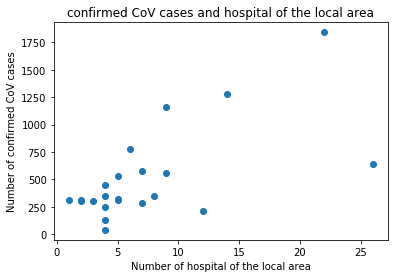

In [498]:
plot = wales_hospital_merged[['Cases','hospital_sum']]
x = plot['hospital_sum']
y = plot['Cases']

plt.scatter(x, y, marker='o')
plt.title('confirmed CoV cases and hospital of the local area')
plt.ylabel('Number of confirmed CoV cases')
plt.xlabel('Number of hospital of the local area')

Text(0, 0.5, 'Number of hospital of the local area')

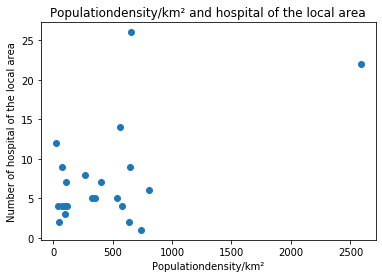

In [503]:
plot = wales_hospital_merged[['hospital_sum','Populationdensity/km²']]
y = plot['hospital_sum']
x = plot['Populationdensity/km²']

plt.scatter(x, y, marker='o')
plt.title('Populationdensity/km² and hospital of the local area')
plt.xlabel('Populationdensity/km²')
plt.ylabel('Number of hospital of the local area')

Text(0, 0.5, 'Number of confirmed CoV cases')

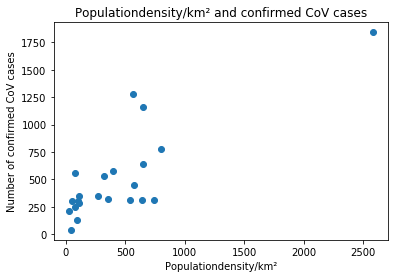

In [502]:
plot = wales_hospital_merged[['Cases','Populationdensity/km²']]
y = plot['Cases']
x = plot['Populationdensity/km²']

plt.scatter(x, y, marker='o')
plt.title('Populationdensity/km² and confirmed CoV cases')
plt.xlabel('Populationdensity/km²')
plt.ylabel('Number of confirmed CoV cases')

#### With limited data, I cannot acquire the number of recovery of each area, therefore it is impossible to see a positive relation between recovery and the numeber of hospital. Number of cases and number of hospital actually shows a positive trend here, which could be both decided by the city but should also be effected by others.

In [507]:
msk = np.random.rand(len(wales_hospital_merged)) < 0.8
train = wales_hospital_merged [msk]
test = wales_hospital_merged [~msk]

In [511]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['Populationdensity/km²','Emergency Room','Hospital','Hospital Ward','Medical Center','Urgent Care Center']])
y = np.asanyarray(train[['Cases']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[  0.56618135 211.58351877  23.28692064 -72.51898796  97.29994584
   78.87931902]]


In [515]:
print('Variance score: %.2f' % regr.score(x, y))

Variance score: 0.90


# Report

## Introduction:
Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people who fall sick with COVID-19 will experience mild to moderate symptoms and recover without special treatment. However, a part of people could show severe symptoms and need professional medical machines to save lives.
The major challenges to medical service come from two aspects:
a large number of suspect cases that need consultation and diagnoses service from hospitals
COVID-19 as a novel antigen that the human immune system did not have memory immune responses to fight back that patients could be easy to show symptoms and need professional medical machines, like breathing machine.
Also, human-to-human transmission as the major transmission pathway that population density could show a positive relation with infection cases.
More infection cases need more medical resources. My question here is whether the number of local hospital is positive related to the number of infection cases? Whether there is any obvious shortage on medical resources that cannot afford a large number of patients.

## Data:
Here, I look into a small area of the United Kingdom, Wales.
Data collection: 
I downloaded infection cases in each county of wales updated on 12-May-2020 from New York Times (https://www.nytimes.com/interactive/2020/world/europe/united-kingdom-coronavirus-cases.html)),
population density information by Wikipedia(https://en.wikipedia.org/wiki/List_of_Welsh_principal_areas_by_population),
I also used foursquare to search hospitals in each county and select those could provide medical service for patients into the analysis.

## Methodology:
1. Show the folium map of Wales and chloroma shows the population density of each county.
2. Mark in the folium map with dots, and the radius is related to the number of infection.
3. Use geopy to acquire the location of center of each county.
4. Use foursquare to search the hospital information with the center of each county.
5. Clean data to remove types of hospital cannot provide service to patients.
6. Provide information of number of different types of hospital in each county.
7. Plot different attribuates with infection cases to see whether there is any clear positive correlation.
8. Scikit-learn to implement Multiple linear regression: split the data into training and test sets, create a model using training set, Evaluate the model using test set.

## Results:
Overall, It seems the popular counties with higer population density will buil more hospitals, at the same time, the infection cases are much higher. Everything seems like positive correlation to the number of infection cases.

## Discussion:
Although everything seems positive related to the infection cases identified in each county, but they could be co-founders, not really directly liner related to each other. Based on knowledge, hospital number could be stronger related to recovery number, but this is unavailable. With limited data, I cannot acquire the number of recovery of each area, therefore it is impossible to see a positive relation between recovery and the numeber of hospital. Number of cases and number of hospital actually shows a positive trend here, which could be both decided by the city but should also be effected by others.

## Conclusion:
More popular county attracts more people that result in a higer density that built more fundmental buildings, including hospitals, to convenient daily life. In 2019 COVID-19, more popular city has more hospitals and provide more medical serive, which should has lower number on patients. However, higher population density is easier for human-to-human transmisssion, which reflect o the data is that infection cases are higher, which is more significant than number of the hospital attribuates.
